<a href="https://colab.research.google.com/github/afonsotmm/computer-vision-lego-kit-assembly/blob/main/lego_kit_assembly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Identification**

* **Name:** Afonso Tomás de Magalhães Mateus
* **Student Number:** 202204126

* **Name:** Diogo Soares de Albergaria Oliveira
* **Student Number:** 202108325


---




# **Initial setup**

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import numpy as np
import cv2 as cv
from google.colab.patches import cv2_imshow
import glob
import os
import matplotlib.pyplot as plt
from dataclasses import dataclass

# **Exercise 1**
>This exercise aims to calibrate the camera used in the Lego inspection setup to obtain accurate geometric parameters for subsequent image analysis. The calibration process involves estimating the intrinsic parameters (focal length, principal point, and distortion coefficients) and the extrinsic parameters that describe the camera's position and orientation relative to the scene. From these results, a precise pixel-to-millimeter conversion factor is derived, enabling reliable measurement and object size estimation in later tasks.

### **Ex.1 Assets**

* **ChessboardParameters Class**

In [27]:
@dataclass
class ChessboardParameters:
  columns_number: int
  rows_number: int
  square_size_meters: float

* **Known Chessboard's Parameters**

In [28]:
# Columns number:     12
# Rows number:         9
# Square size (mm):   15

chessboard_parameters = ChessboardParameters(12, 9, 0.015)

* **CalibrationResult Class**

In [29]:
@dataclass
class CalibrationResult:
  ret: float
  K: np.ndarray
  dist: np.ndarray
  rvecs: list
  tvecs: list

**1. Re-projection Error ($\text{ret}$):**
$$
\text{error} =
\sqrt{\frac{1}{M}\sum_{i=1}^{M}\lVert x_i - \hat{x}_i \rVert^2}
$$
This value measures the average pixel difference between detected and projected points.

<br><br>

**2. Intrinsic Matrix ($K$):**
$$
K =
\begin{bmatrix}
f_x & 0 & c_x \\
0 & f_y & c_y \\
0 & 0 & 1
\end{bmatrix}
$$
where  
- $ f_x, f_y $: focal lengths in pixels  
- $ c_x, c_y $: coordinates of the optical center  

<br><br>

**2. Distortion Coefficients ($\text{dist}$):**
$$
\text{dist} = [k_1,\; k_2,\; p_1,\; p_2,\; k_3]
$$
where  
- $ k_1, k_2, k_3 $: radial distortion terms  
- $ p_1, p_2 $: tangential distortion terms  

<br><br>

**3. Rotation Vectors ($r_{vecs}$):**
$$
r_{vec_i} =
\begin{bmatrix}
r_x \\
r_y \\
r_z
\end{bmatrix},
\quad i = 1, \dots, N
$$
Each vector defines the **orientation** of the camera relative to the calibration pattern in image $i$.

<br><br>

**4. Translation Vectors ($t_{vecs} $):**
$$
t_{vecs_i}  =
\begin{bmatrix}
t_x \\
t_y \\
t_z
\end{bmatrix},
\quad i = 1, \dots, N
$$
Each vector defines the **position** of the camera relative to the calibration pattern in image $i$.


* **Calibration function**

In [30]:
# -> Compute World referential points and its correspondency at the Image referential (3D (meters) -> 2D (pixels))
def calibrate_via_chessboard(images, chessboard_parameters, show):

  # Termination criteria
  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

  # Parameters
  chessboard_corners_x = chessboard_parameters.columns_number - 1
  chessboard_corners_y = chessboard_parameters.rows_number - 1

  # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
  objp = np.zeros((chessboard_corners_y*chessboard_corners_x,3), np.float32)
  objp[:,:2] = np.mgrid[0:chessboard_corners_x,0:chessboard_corners_y].T.reshape(-1,2)
  objp = chessboard_parameters.square_size_meters * objp

  # Arrays to store object points and image points from all the images.
  objpoints = [] # 3d point in real world space
  imgpoints = [] # 2d points in image plane.

  image_size = None # Initialize image_size before the loop

  for fname in images:
    img = cv.imread(fname)
    if img is None:
        continue
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    image_size = gray.shape[::-1] # Define image_size

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (chessboard_corners_x, chessboard_corners_y), None)

    # If found, add object points, image points (after refining them)
    if ret == True:
      objpoints.append(objp)

      corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
      imgpoints.append(corners2)

      if show == True:
        # Draw and display the corners
        cv.drawChessboardCorners(img, (chessboard_corners_x, chessboard_corners_y), corners2, ret)
        cv2_imshow(img)

  # Calibrate
  # Check if imgpoints is not empty before calling calibrateCamera
  if imgpoints:
      ret, K, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, image_size, None, None)
  else:
      ret, K, dist, rvecs, tvecs = False, None, None, None, None # Return None or appropriate values if calibration fails


  return ret, K, dist, rvecs, tvecs

* **Undistort function**

In [31]:
def undistort_image(image, K, dist, alpha):

  # Scalling
  h, w = image.shape[:2]

  newcamera_K, roi = cv.getOptimalNewCameraMatrix(K, dist, (w,h), alpha, (w,h))

  # undistort
  undst_img = cv.undistort(image, K, dist, None, newcamera_K)

  # crop the image
  x, y, w_roi, h_roi = roi
  if w_roi > 0 and h_roi > 0:
      undst_img = undst_img[y:y+h_roi, x:x+w_roi]

  return undst_img

* **Get Extrinsic Parameters function**
> **Note**: This function assumes that the image received is already undistorced (that's why we consider dist = None)

In [32]:
def get_extrinsic_parameters(undst_img, intrinsic_parameters, chessboard_parameters):

  # Parameters
  chessboard_corners_x = chessboard_parameters.columns_number - 1
  chessboard_corners_y = chessboard_parameters.rows_number - 1

  objp = np.zeros((chessboard_corners_x*chessboard_corners_y,3), np.float32)
  objp[:,:2] = np.mgrid[0:chessboard_corners_x,0:chessboard_corners_y].T.reshape(-1,2)
  objp = chessboard_parameters.square_size_meters * objp

  gray = cv.cvtColor(undst_img,cv.COLOR_BGR2GRAY)
  ret, corners = cv.findChessboardCorners(gray, (chessboard_corners_x,chessboard_corners_y), None)
  dist = None

  if not ret:
      raise RuntimeError("[get_extrinsic_parameters]: findChessboardCorners failed")

  # Find the rotation and translation vectors.
  pnp_ret, rvec, tvec = cv.solvePnP(objp, corners, intrinsic_parameters.K, dist)

  if pnp_ret == False:

    raise RuntimeError("[get_extrinsic_parameters]: solvePnP failed.")

  return rvec, tvec, corners

### **(a) - Intrinsic Calibration**

>Estimation of intrinsic parameters and lens distortion coefficients from multiple calibration attempts, followed by selection of the configuration with the lowest reprojection error.


**(i) Calibration 1**












In [33]:
folder_calib_1 = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Projects/Project_#1/assign1_data/Calibration/calib1/'
images_1 = sorted(glob.glob(folder_calib_1 + '*.png'))
show_images_1 = False

ret_1, K_1, dist_1, rvecs_1, tvecs_1 = calibrate_via_chessboard(images_1, chessboard_parameters, show_images_1)

calib_1 = CalibrationResult(ret_1, K_1, dist_1, rvecs_1, tvecs_1)

# --- Debug ----
print(" -> Intrinsic Matrix: ")
print(calib_1.K)

print("")

print(" -> Distorion Coefficients: ")
print(calib_1.dist)

print("")

print(f" -> Re-projection Error: {calib_1.ret}")


 -> Intrinsic Matrix: 
[[827.57850219   0.         334.83395629]
 [  0.         827.43751149 281.31040416]
 [  0.           0.           1.        ]]

 -> Distorion Coefficients: 
[[-0.43653625  0.40330902 -0.0013504   0.00154947 -0.53358644]]

 -> Re-projection Error: 0.9256905073033473


* **Intrinsic Matrix (K):**
<br>
$$
K = \begin{bmatrix}
827.5785 & 0 & 334.8340 \\
0 & 827.4375 & 281.3104 \\
0 & 0 & 1
\end{bmatrix}
$$

<br><br>

* **Distortion Coefficients:**
<br>
$$
\text{dist} =
\begin{bmatrix}
-0.4365 & 0.4033 & -0.0014 & 0.0015 & -0.5336
\end{bmatrix}
$$

<br><br>

* **Re-projection Error:**
$$ E_{RMS} = 0.9257 $$

<br>

---


**(ii) Calibration 2**

In [34]:
folder_calib_2 = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Projects/Project_#1/assign1_data/Calibration/calib2/'
images_2 = sorted(glob.glob(folder_calib_2 + '*.png'))
show_images_2 = False

ret_2, K_2, dist_2, rvecs_2, tvecs_2 = calibrate_via_chessboard(images_2, chessboard_parameters, show_images_2)

calib_2 = CalibrationResult(ret_2, K_2, dist_2, rvecs_2, tvecs_2)

# --- Debug ----
print(" -> Intrinsic Matrix: ")
print(calib_2.K)

print("")

print(" -> Distorion Coefficients: ")
print(calib_2.dist)

print("")

print(f" -> Re-projection Error: {calib_2.ret}")

 -> Intrinsic Matrix: 
[[839.07615265   0.         339.34164595]
 [  0.         839.32227556 276.31090529]
 [  0.           0.           1.        ]]

 -> Distorion Coefficients: 
[[-4.32165948e-01  2.83161213e-01 -2.23956506e-04  4.15190941e-04
  -1.38438500e-01]]

 -> Re-projection Error: 0.09807000525111947


* **Intrinsic Matrix (K):**
<br>
$$
K = \begin{bmatrix}
839.0762 & 0 & 339.3416 \\
0 & 839.3223 & 276.3109 \\
0 & 0 & 1
\end{bmatrix}
$$

<br><br>

* **Distortion Coefficients:**
<br>
$$
\text{dist} =
\begin{bmatrix}
-0.4322 & 0.2832 & -0.0002 & 0.0004 & -0.1384
\end{bmatrix}
$$

<br><br>

* **Re-projection Error:**
$$ E_{RMS} = 0.0981 $$

<br>

---

**(iii) Calibration 3**


In [35]:
folder_calib_3 = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Projects/Project_#1/assign1_data/Calibration/calib3/'
images_3 = sorted(glob.glob(folder_calib_3 + '*.png'))
show_images_3 = False

ret_3, K_3, dist_3, rvecs_3, tvecs_3 = calibrate_via_chessboard(images_3, chessboard_parameters, show_images_3)

calib_3 = CalibrationResult(ret_3, K_3, dist_3, rvecs_3, tvecs_3)

# --- Debug ----
print(" -> Intrinsic Matrix: ")
print(calib_3.K)

print("")

print(" -> Distorion Coefficients: ")
print(calib_3.dist)

print("")

print(f" -> Re-projection Error: {calib_3.ret}")

 -> Intrinsic Matrix: 
[[837.55342254   0.         338.44589428]
 [  0.         837.73983656 276.54574964]
 [  0.           0.           1.        ]]

 -> Distorion Coefficients: 
[[-4.45524998e-01  3.95183801e-01 -4.52503299e-04  2.07693657e-04
  -4.44972736e-01]]

 -> Re-projection Error: 0.5066609032930021


* **Intrinsic Matrix (K):**
<br>
$$
K = \begin{bmatrix}
837.5534 & 0 & 338.4459 \\
0 & 837.7398 & 276.5457 \\
0 & 0 & 1
\end{bmatrix}
$$

<br><br>

* **Distortion Coefficients:**
<br>
$$
\text{dist} =
\begin{bmatrix}
-0.4455 & 0.3952 & -0.0005 & 0.0002 & -0.4450
\end{bmatrix}
$$

<br><br>

* **Re-projection Error:**
$$ E_{RMS} = 0.5067 $$

<br>

---

**Choosing the best Calibration set of images**


In [36]:
calibrations = {
  "Calibration_1": calib_1,
  "Calibration_2": calib_2,
  "Calibration_3": calib_3
}

best_name = None
best_calib = None
min_error = float('inf')

for name, calib in calibrations.items():
  if calib.ret < min_error:
      min_error = calib.ret
      best_name = name
      best_calib = calib

print("")
print(f"Best calibration: {best_name} (error = {best_calib.ret})")


Best calibration: Calibration_2 (error = 0.09807000525111947)


### **Results**

Set 2 is selected because it offers the widest pose diversity and field-of-view coverage (center and all four corners under multiple orientations) with consistently sharp imagery, yielding the lowest RMS re-projection error.
Set 1 is limited by poor pose variation (orientation and position), while Set 3, despite greater diversity than Set 1, contains occasional defocus and remains less diverse than Set 2.

<br>

This finding is consistent with the **RMS re-projection errors** for the three calibration sets:

$$ E_{\text{RMS}}(\text{Set 2}) \;<\; E_{\text{RMS}}(\text{Set 3}) \;<\; E_{\text{RMS}}(\text{Set 1}) $$

$$\quad (0.098 \;<\; 0.507 \;<\; 0.926) $$



---



### **(b) - Extrinsic Calibration**

>Estimation of the camera pose (rotation and translation) from “final setup.png”, with reporting of the extrinsic matrix
$[R ∣ t]$ and derivation of the pixel-to-millimeter conversion factor for subsequent metric measurements.

Once the intrinsic and distortion parameters of the camera have been determined, an undistorted image can be obtained. Considering that final_setup.png captures the same camera pose relative to the inspection plane as in the Lego acquisition (i.e., identical distance and orientation with respect to the plane), the extrinsic matrix was estimated to characterize this geometry. From this calibration, the pixel-to-millimeter conversion factor was derived and will be used in the subsequent analysis of the Lego images acquired on the same plane.

**Setup image undistortion**

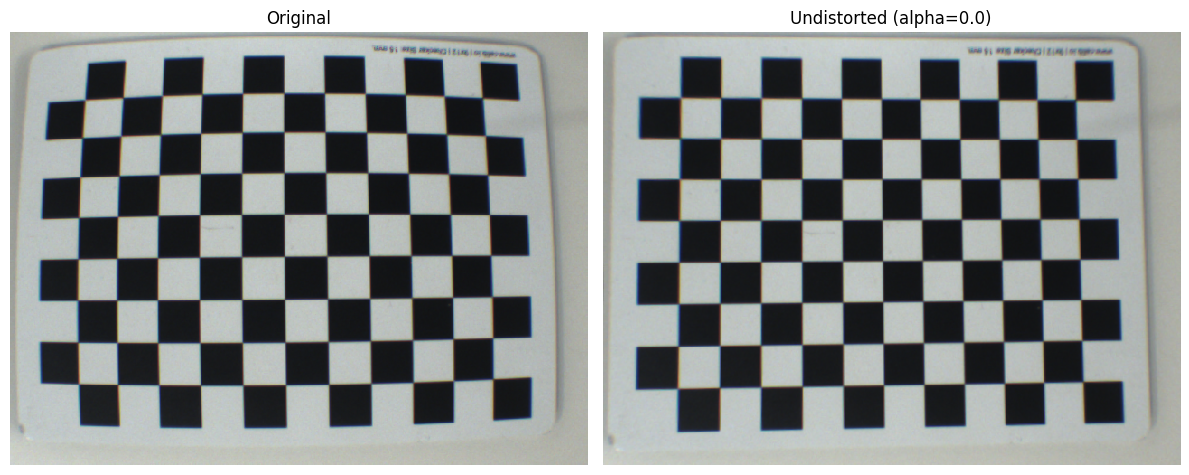

In [37]:
setup_image = cv.imread('/content/drive/MyDrive/Colab Notebooks/Computer Vision/Projects/Project_#1/assign1_data/Calibration/final_setup.png')

K = best_calib.K
dist = best_calib.dist

alpha = 0.0
undst_img = undistort_image(setup_image, K, dist, alpha)

# ---- Show side by side with matplotlib ----
orig_rgb = cv.cvtColor(setup_image, cv.COLOR_BGR2RGB)
und_rgb  = cv.cvtColor(undst_img, cv.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(orig_rgb, interpolation='nearest')
axes[0].set_title("Original"); axes[0].axis('off')

axes[1].imshow(und_rgb, interpolation='nearest')
axes[1].set_title(f"Undistorted (alpha={alpha})"); axes[1].axis('off')

plt.tight_layout()
plt.show()

# -------------------------------------------


**Calibration of the extrinsic parameters of the camera setup**


In [38]:
rvec, tvec, corners = get_extrinsic_parameters(undst_img, best_calib, chessboard_parameters)
# rvec: 3x1; tvec: 3x1;  R: 3x3;  [R|t]: 3x4
R, _ = cv.Rodrigues(rvec)
world_to_cam = np.hstack([R, tvec])

print(" -> Extrinsic Matrix: ")
print(world_to_cam)


 -> Extrinsic Matrix: 
[[-0.99781443 -0.01109167 -0.06514096  0.06524178]
 [ 0.00896863 -0.99942189  0.03279402  0.03647397]
 [-0.06546704  0.03213812  0.99733706  0.28527033]]


**Estimation of the pixel-to-millimeter conversion factor**


To estimate the pixel-to-millimeter conversion factor, the average distance between adjacent corners of the calibration chessboard was computed in pixel units. Considering the known physical size of each square, this ratio provides a reliable scale conversion between image measurements and real-world dimensions.

In [80]:
pixel_distance = np.linalg.norm(corners[1] - corners[0])
square_size_mm = chessboard_parameters.square_size_meters*1000
pixel_per_mm = pixel_distance / square_size_mm
print(f" -> Ratio (px/mm): {pixel_per_mm:.2f}")

 -> Ratio (px/mm): 2.88


With both the intrinsic and extrinsic calibration parameters established, the camera model is now fully defined, enabling its use for accurate metric measurements and object analysis in the Lego image dataset.

---

# **Exercise 2**
>This exercise focuses on analyzing isolated LEGO brick images to extract quantitative information about their color, size, and area. A region of interest (ROI) is first defined to isolate the relevant part of each image and remove background noise. The image “colored bricks.png” is then processed to count the number of bricks grouped by color. Subsequently, for the individual color images (“blue.png”, “green.png”, “red.png”, and “yellow.png”), the bricks are grouped by size (e.g., 2x1, 2x2, 2x4), and their average area and standard deviation are calculated in both pixels and square millimeters using the previously obtained pixel-to-millimeter conversion factor. The results are summarized in a table presenting the average area and variability for each brick size and color, providing a quantitative basis for the classification and verification tasks in the following exercises.


## **Ex.2 Assets**

**Color Ranges (HSV)**
> Obtained Experimentally

In [142]:
COLOR_RANGES = {
  'blue': {
      'light': ([  70, 138,  75], [ 108, 182, 255]),
      'dark':  ([ 108, 172,  75], [ 134, 255, 255]),
  },
  'green': {
      'light': ([  32, 106,   0], [  68, 255, 255]),
      'dark':  ([  32,  81, 125], [  68, 255, 255]),
  },
  'yellow': {
      'light': ([  11, 151, 112], [  29, 255, 255]),
      'dark':  ([  22, 120, 149], [ 180, 255, 255]),
  },
  'red': {
      'light': ([   0, 150,  75], [  10, 255, 255]),
      'dark':  ([ 170, 150,  75], [ 180, 255, 255]),
  },
  'white': ([   0,   0,   0], [   0,   0,   0])
}

**Available Brick's Colors (BGR)**

In [ ]:
BRICK_COLORS = {
    "blue":   (255, 0, 0),
    "green":  (0, 255, 0),
    "yellow": (0, 255, 255),
    "red":    (0, 0, 255),
    "white":  (255, 255, 255),
}

**Brick's Known Sizes**

In [68]:
# in mm^2 (w*h)
BRICK_SIZES = {
  '2x1':  32*15,
  '2x2':  32*32,
  '2x4':  32*64,
  '2x6':  32*95,
  'R2x2': 32*47,
}

###**Relevant Classes:**

* **Pose Class**


In [90]:
@dataclass
class Pose:
  x: float
  y: float

* **Dimension and UnitAwareDimension Classes:**

In [91]:
# ==============================================
#               Dimension Class
# ==============================================
@dataclass(slots=True)
class Dimension:
    width:  float
    height: float

    @property
    def area(self) -> float:
        return self.width * self.height


# =====================================================
#              UnitAwareDimension Class
# =====================================================
class UnitAwareDimension:
  def __init__(self, pixel_per_mm=2.88, width_px=None, height_px=None, width_mm=None, height_mm=None):

    self.pixel_per_mm = pixel_per_mm

    if width_px is not None and width_mm is None:
      width_mm = self.convert_to_mm(width_px)

    if width_mm is not None and width_px is None:
      width_px = self.convert_to_px(width_mm)

    if height_px is not None and height_mm is None:
      height_mm = self.convert_to_mm(height_px)

    if height_mm is not None and height_px is None:
      height_px = self.convert_to_px(height_mm)

    if height_mm is None and height_px is None:
      raise ValueError("Invalid height")
    if width_mm is None and width_px is None:
      raise ValueError("Invalid width")

    self.dimension_px = Dimension(width_px, height_px)
    self.dimension_mm = Dimension(width_mm, height_mm)



  def convert_to_mm(self, px):
    return (px / self.pixel_per_mm)

  def convert_to_px(self, mm):
    return (mm * self.pixel_per_mm)

* **BoxShape Class**
> For simplicity we consider that the contour that surrounds the Lego Brick is a box

In [92]:
class BoxShape:
  def __init__(self, contour):
    self.contour = contour
    self.rect, self.box_points = self.compute_box()
    self.dimension = self.compute_dimensions()
    self.centroid  = self.compute_centroid()

  def compute_box(self):
    rect = cv.minAreaRect(self.contour)
    box_points = cv.boxPoints(rect).astype(int)
    return rect, box_points

  def compute_dimensions(self):
    (w, h) = self.rect[1]
    return UnitAwareDimension(width_px=w, height_px=h, pixel_per_mm=pixel_per_mm)

  def compute_centroid(self):
    M = cv.moments(self.contour)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return Pose(cx, cy)


* **LegoBrick Class**


In [93]:
@dataclass
class LegoBrick:
  id: int
  color: str
  size_class: str
  shape: BoxShape

* **MultiFormat Class**

  > To make later processing easier, a small class is used to store several color versions of the same image. For simplicity, the current version assumes the input is in BGR, from which it creates and stores the other versions of the same image (RGB, HSV and grayscale).

In [94]:
class MultiFormat:
    def __init__(self, *, bgr=None, rgb=None, hsv=None, gray=None):

        inputs = [bgr, rgb, hsv, gray]
        num_inputs = sum(x is not None for x in inputs)

        if num_inputs > 1:
            raise ValueError("Provide just one image format")

        if bgr is not None:
            self.bgr = bgr
        elif rgb is not None:
            self.bgr = cv.cvtColor(rgb, cv.COLOR_RGB2BGR)
        elif hsv is not None:
            self.bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
        elif gray is not None:
            self.bgr = cv.cvtColor(gray, cv.COLOR_GRAY2BGR)

        self.rgb  = cv.cvtColor(self.bgr, cv.COLOR_BGR2RGB)
        self.hsv  = cv.cvtColor(self.bgr, cv.COLOR_BGR2HSV)
        self.gray = cv.cvtColor(self.bgr, cv.COLOR_BGR2GRAY)

* **Image Class**

In [165]:
class Image:
  def __init__(self, name, multiformat_image: MultiFormat):
    self.name = name
    self.formats = multiformat_image
    self.masks = self.get_masks()
    self.bricks: list[LegoBrick] = []

  # ===== Contour's Detection and Drawing =====
  def get_contours(self, mask, min_area=200, preprocess=False):
    if preprocess:
        mask = cv.medianBlur(mask, 5)
        kernel = np.ones((5, 5), np.uint8)
        mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    kept = []
    for cnt in contours:
      area = cv.contourArea(cnt)
      if area >= float(min_area):
          kept.append(cnt)
    return kept

  # ========== Masks Computation ===========
  def get_masks(self):

      hsv = self.formats.hsv
      masks = {
          'blue': cv.bitwise_or(
              cv.inRange(hsv, np.array(color_ranges['blue']['light'][0]), np.array(color_ranges['blue']['light'][1])),
              cv.inRange(hsv, np.array(color_ranges['blue']['dark'][0]),  np.array(color_ranges['blue']['dark'][1]))
          ),

          'green': cv.bitwise_or(
              cv.inRange(hsv, np.array(color_ranges['green']['light'][0]), np.array(color_ranges['green']['light'][1])),
              cv.inRange(hsv, np.array(color_ranges['green']['dark'][0]),  np.array(color_ranges['green']['dark'][1]))
          ),

          'yellow': cv.bitwise_or(
              cv.inRange(hsv, np.array(color_ranges['yellow']['light'][0]), np.array(color_ranges['yellow']['light'][1])),
              cv.inRange(hsv, np.array(color_ranges['yellow']['dark'][0]),  np.array(color_ranges['yellow']['dark'][1]))
          ),

          'red': cv.bitwise_or(
              cv.inRange(hsv, np.array(color_ranges['red']['light'][0]), np.array(color_ranges['red']['light'][1])),
              cv.inRange(hsv, np.array(color_ranges['red']['dark'][0]),  np.array(color_ranges['red']['dark'][1]))
          ),

          # 'white': cv.inRange(hsv, np.array(color_ranges['white'][0]), np.array(color_ranges['white'][1])),
      }

      return masks

  # ============= Bricks Manage =============
  def add_brick(self, brick: LegoBrick):
    self.bricks.append(brick)

  def initialize_bricks(self):
    self.bricks = []

  def build_bricks(self, *, min_area = 200.0, preprocess = False, draw = False, centroid_show = False):

    self.bricks = []
    next_id = 1

    for color, mask in self.masks.items():
        contours = self.get_contours(mask=mask, min_area=min_area, preprocess=preprocess)

        # Creating a LegoBrick for each contour
        for cnt in contours:
            shape = BoxShape(cnt)
            brick = LegoBrick(id=next_id, color=color, size_class="unknown", shape=shape)
            self.bricks.append(brick)
            next_id += 1

    if draw:
        out = self.formats.bgr.copy()
        for brick in self.bricks:
            box = brick.shape.box_points
            cv.drawContours(out, [box], -1, color_draw[brick.color], 2)
            cx, cy = int(brick.shape.centroid.x), int(brick.shape.centroid.y)
            cv.putText(out, str(brick.id), (cx + 5, cy - 5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color_draw["green"], 1, cv.LINE_AA)
            if centroid_show:
              cv.circle(out, (cx, cy), 3, color_draw["green"], -1)

        plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
        plt.title(f"Detected Bricks: {len(self.bricks)}")
        plt.axis("off")
        plt.show()

    return self.bricks

  def get_bricks_by_color(self, color):
    result = []
    for brick in self.bricks:
        if brick.color == color:
            result.append(brick)
    return result


  def get_bricks_by_size(self, size_class):
    result = []
    for brick in self.bricks:
        if brick.size_class == size_class:
            result.append(brick)
    return result


  def get_bricks_by_color_and_size(self, color, size_class):
    result = []
    for brick in self.bricks:
        if brick.color == color and brick.size_class == size_class:
            result.append(brick)
    return result



###**Setup**

>The isolated set of images is first undistorted using the intrinsic parameters and distortion coefficients. Each undistorted result is stored as an ImageMultiFormat object for convenient access to RGB/HSV/gray views.

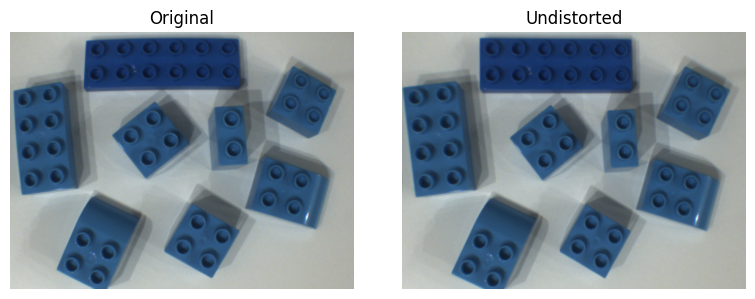

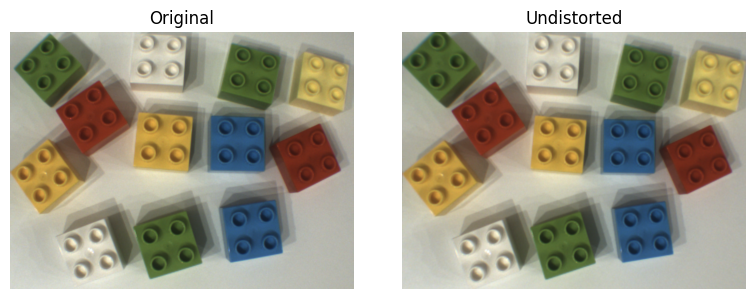

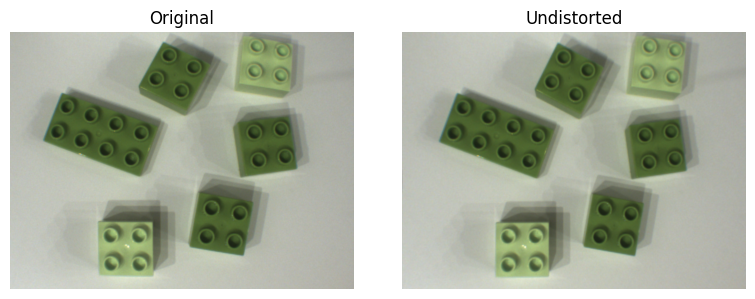

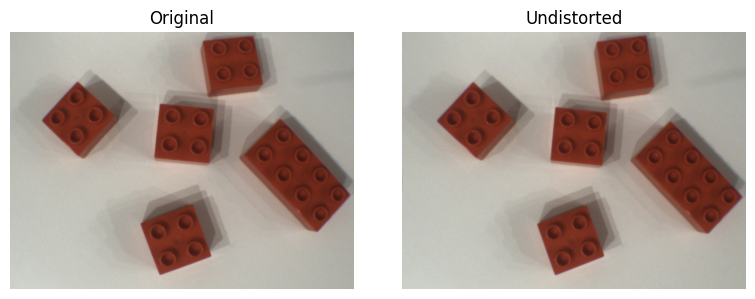

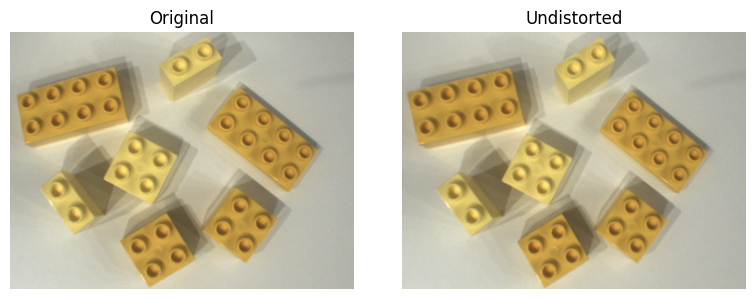

In [167]:
isolated_images_folder = '/content/drive/MyDrive/Colab Notebooks/Computer Vision/Projects/Project_#1/assign1_data/Isolated'
isolated_original_images = sorted(glob.glob(isolated_images_folder + '/*.png'))
isolated_undistorted_images = []

for image_path in isolated_original_images:
  img = cv.imread(image_path)
  undst_img = undistort_image(img, K, dist, alpha)
  isolated_undistorted_images.append(Image(image_path, MultiFormat(bgr=undst_img)))

# Plot
for i, path in enumerate(isolated_original_images):
  orig_rgb = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)
  und_rgb  = isolated_undistorted_images[i].formats.rgb

  plt.figure(figsize=(8,3))
  plt.subplot(1,2,1); plt.imshow(orig_rgb); plt.title("Original"); plt.axis('off')
  plt.subplot(1,2,2); plt.imshow(und_rgb);  plt.title("Undistorted"); plt.axis('off')
  plt.tight_layout(); plt.show()

### **(a) - Region of Interest (ROI) Definition**

>Identification and selection of a specific region within the image that contains the LEGO bricks, excluding irrelevant background areas.


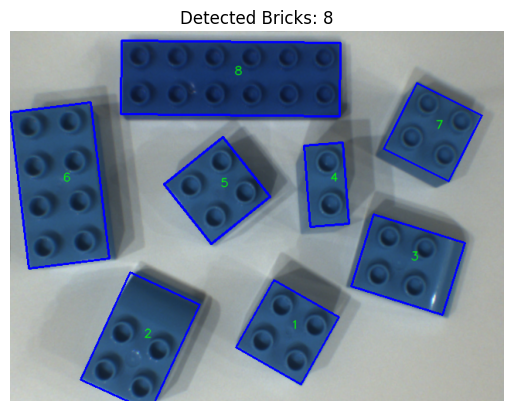

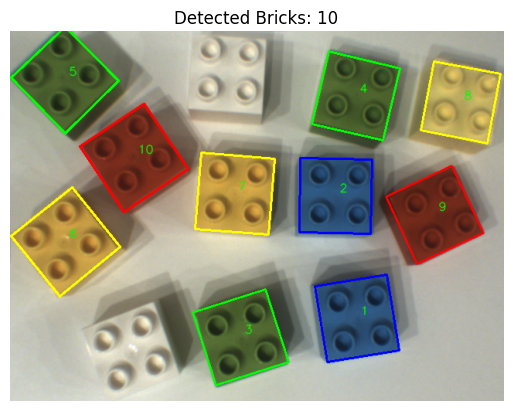

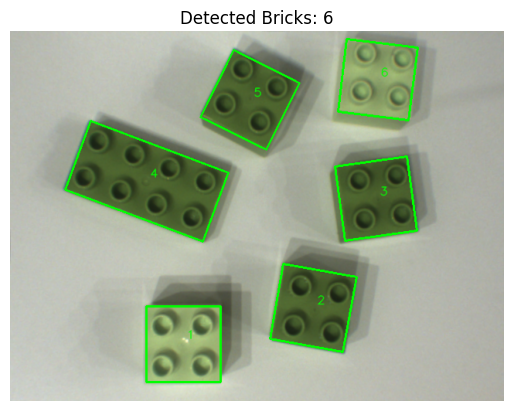

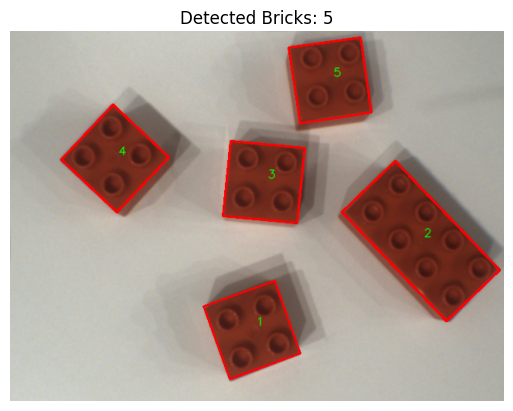

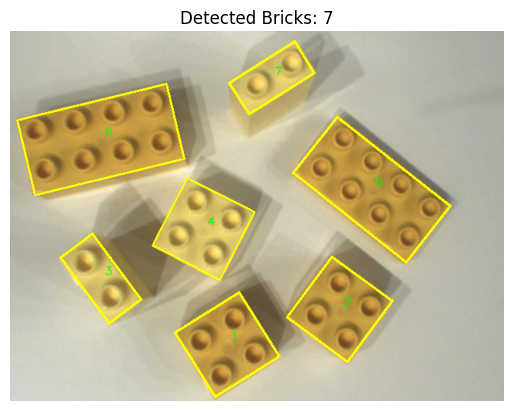

In [168]:
for img in isolated_undistorted_images:
  img.build_bricks(min_area = 200.0, preprocess = True, draw = True, centroid_show = False)

### **(b) - Brick Color Counting**

> Detection and counting of LEGO bricks in the image “colored bricks.png”, grouping them according to their color categories.

In [ ]:
for

c)

w=33.58085250854492
w=34.306095123291016
w=42.87470245361328
w=36.51252746582031
w=33.89064407348633
w=70.47570037841797
w=32.55604934692383
w=98.28743743896484


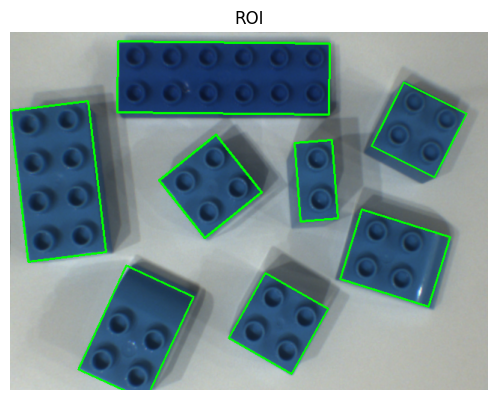


w=34.484825134277344
w=32.129886627197266
w=34.324954986572266
w=32.95001220703125
w=34.676483154296875
w=34.487247467041016
w=33.142005920410156
w=30.437116622924805
w=33.15569305419922
w=35.412940979003906


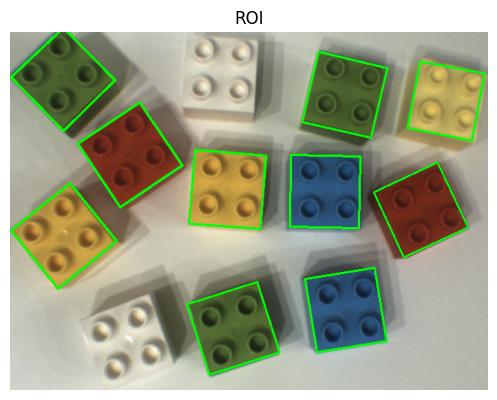


w=33.97218322753906
w=33.22377395629883
w=33.66066360473633
w=65.96247863769531
w=32.86610412597656
w=31.854557037353516


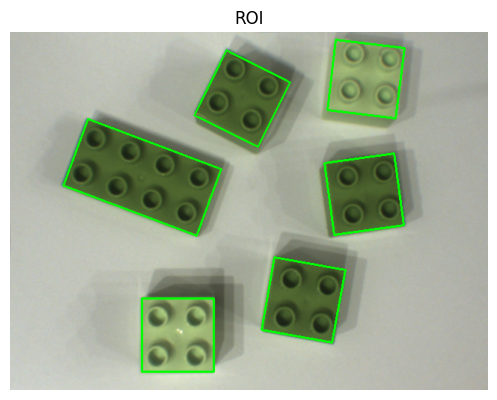


w=34.669952392578125
w=67.5157470703125
w=33.37546920776367
w=34.3310432434082
w=34.164222717285156


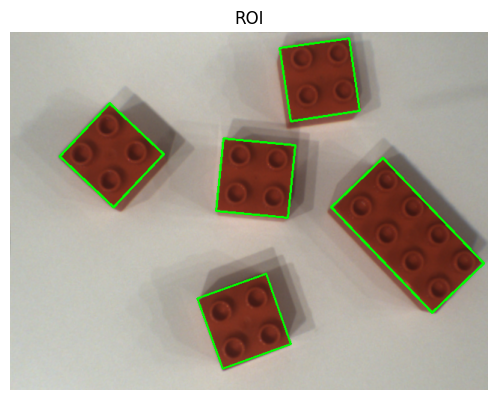


w=33.95270538330078
w=33.476837158203125
w=36.65267562866211
w=33.815330505371094
w=64.56680297851562
w=34.40251922607422
w=16.742727279663086


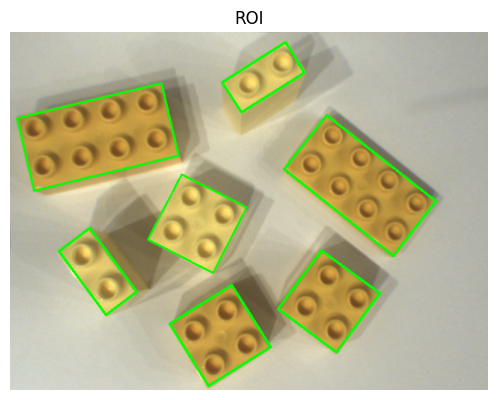

In [48]:
color_draw = {
    'black':   (0, 255, 0),
}

bricks_grouped_by_size = {
  '2x1':  [],
  '2x2':  [],
  '2x4':  [],
  '2x6':  [],
  'R2x2': [],
}
min_area = 230
i = 0

for img in isolated_undistorted_images:
    hsv  = img.hsv
    rgb = img.rgb

    masks = {
        'blue'  : cv.bitwise_or(
                    cv.inRange(hsv, np.array(color_ranges['blue1'][0]), np.array(color_ranges['blue1'][1])),
                    cv.inRange(hsv, np.array(color_ranges['blue2'][0]), np.array(color_ranges['blue2'][1]))),

        'green' : cv.bitwise_or(
                    cv.inRange(hsv, np.array(color_ranges['green1'][0]), np.array(color_ranges['green1'][1])),
                    cv.inRange(hsv, np.array(color_ranges['green2'][0]), np.array(color_ranges['green2'][1]))),

        'yellow': cv.bitwise_or(
                    cv.inRange(hsv, np.array(color_ranges['yellow1'][0]), np.array(color_ranges['yellow1'][1])),
                    cv.inRange(hsv, np.array(color_ranges['yellow2'][0]), np.array(color_ranges['yellow2'][1]))),

        'red'   : cv.bitwise_or(
                    cv.inRange(hsv, np.array(color_ranges['red1'][0]), np.array(color_ranges['red1'][1])),
                    cv.inRange(hsv, np.array(color_ranges['red2'][0]), np.array(color_ranges['red2'][1]))),

        #'white' : cv.inRange(hsv, np.array(color_ranges['white'][0]),  np.array(color_ranges['white'][1])),
    }

    out_contour = rgb.copy()
    out_box = rgb.copy()

    for cname, mask in masks.items():
        col = color_draw["black"]

        valid_contours = []

        out_box, valid_contours = draw_contour_boxes(
            out_box, mask=mask, color=col,
            min_area=min_area, title="Contours (box)", preprocess=True, show=False
        )

        if len(valid_contours) > 0:
          for cnt in valid_contours:
            rect = cv.minAreaRect(cnt)
            (w, h) = rect[1]
            area_wh = float(w*h)/(ratio ** 2)  # área do retângulo rotacionado em px²

            box = cv.boxPoints(rect).astype(np.float32)
            area_poly = cv.contourArea(box)/(ratio ** 2)  # área do quadrilátero em px

            mask = np.zeros(img.rgb.shape[:2], np.uint8)
            cv.fillPoly(mask, [box.astype(np.int32)], 255)
            area_mask = int(cv.countNonZero(mask)) /(ratio ** 2) # px dentro da box
            w = w/ratio
            print(f"w={w}")


    plt.figure(figsize=(10,4))
    plt.subplot(1,2,2); plt.imshow(out_box);     plt.title("ROI");    plt.axis('off')
    plt.tight_layout(); plt.show()
    print("")